# Getting Started with Graph Memory

Mem0 now supports **Graph Memory**.
With Graph Memory, users can now create and utilize complex relationships between pieces of information, allowing for more nuanced and context-aware responses. This integration enables users to leverage the strengths of both vector-based and graph-based approaches, resulting in more accurate and comprehensive information retrieval and generation.


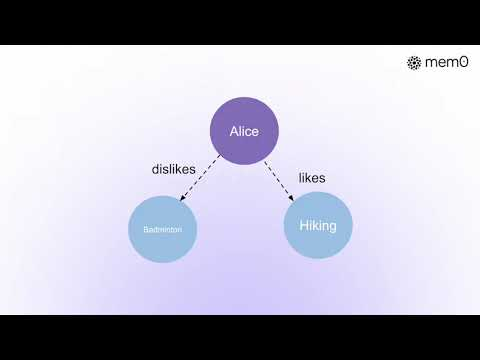

In [1]:
from IPython.display import YouTubeVideo

# Replace the video ID with the one from your YouTube URL
video = YouTubeVideo("u_ZAqNNVtXA", width=720, height=480)
display(video)

<p align="center">
  <a href="https://github.com/mem0ai/mem0" target="_blank">
    <img src="https://img.shields.io/badge/-Mem0(OSS)-green" alt="Mem0 (OSS)">
  </a>
  &nbsp;
  <a href="https://app.mem0.ai/" target="_blank">
    <img src="https://img.shields.io/badge/-Mem0(Platform)-lightpurple" alt="Mem0 (Platform)">
  </a>
  &nbsp;
  <a href="https://docs.mem0.ai/open-source/graph-memory" target="_blank">
    <img src="https://img.shields.io/badge/-Documentation-blue" alt="Documentation">
  </a>
</p>

[Mem0 (OSS)](https://github.com/mem0ai/mem0) |
[Mem0 (Platform)](https://app.mem0.ai/) |
[Documentation](https://docs.mem0.ai/open-source/graph-memory)

## Installing mem0ai and other dependencies

In [2]:
# !pip install mem0ai py2neo netgraph

## Setting the OpenAI API keys

In [3]:
import os

from dotenv import load_dotenv

In [4]:
load_dotenv()

True

## Setting Neo4j credentials

In [5]:
HOST = "localhost"
URL = f"neo4j://{HOST}:{os.getenv('NEO4J_LOCAL_DB_PORT')}"
USERNAME = os.getenv("NEO4J_USER")
PASSWORD = os.getenv("NEO4J_PASSWORD")

In [6]:
os.environ["LANGCHAIN_PROJECT"] = "mem0"

## Graph Visualization Tool

In [7]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
from netgraph import Graph as ngGraph


def display_graph():
    # Neo4j connection configuration
    uri = URL
    username = USERNAME
    password = PASSWORD

    # Connect to Neo4j
    driver = GraphDatabase.driver(uri, auth=(username, password))

    # Updated query to return node names
    query = """
    MATCH (n)
    OPTIONAL MATCH (n)-[r]->(m)
    RETURN n.name AS source_name, type(r) AS relationship_type, m.name AS target_name
    """

    # Function to execute the query and process results
    def get_graph_data(tx):
        result = tx.run(query)
        nodes = set()
        edges = []
        for record in result:
            source_name = record["source_name"]
            target_name = record["target_name"]
            relationship = record["relationship_type"]

            if source_name:
                nodes.add(source_name)
            if target_name:
                nodes.add(target_name)
                edges.append((source_name, target_name, relationship))

        return list(nodes), edges

    # Execute the query and get results
    with driver.session() as session:
        nodes, edges = session.execute_read(get_graph_data)

    # Create a NetworkX directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    G.add_nodes_from(nodes)
    G.add_edges_from([(source, target, {'type': rel_type}) for source, target, rel_type in edges])

    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 12))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # Use netgraph for layout and drawing
    try:
        plot_instance = ngGraph(G, node_layout='spring', node_size=5, node_color='lightblue',
                        edge_width=0.4, edge_alpha=1, edge_color='black',
                        node_labels=True, edge_labels=nx.get_edge_attributes(G, 'type'),
                        arrows=True, ax=ax, arrowsize=1,
                        edge_arrow_width=0.5,
                        node_label_fontdict={'size': 12})
    except:
        plt.clf()
        plt.close(fig)
        ax.clear()
        plt.close('all')
        return "Nothing to Plot, add memories"

    plt.title("Mem0 Graph Memory Visualization", fontsize=20)

    # Enable zoom and pan
    def zoom_factory(ax, base_scale=2.):
        def zoom_fun(event):
            cur_xlim = ax.get_xlim()
            cur_ylim = ax.get_ylim()
            xdata = event.xdata
            ydata = event.ydata
            if event.button == 'up':
                scale_factor = 1/base_scale
            elif event.button == 'down':
                scale_factor = base_scale
            else:
                scale_factor = 1
            new_width = (cur_xlim[1] - cur_xlim[0]) * scale_factor
            new_height = (cur_ylim[1] - cur_ylim[0]) * scale_factor
            relx = (cur_xlim[1] - xdata)/(cur_xlim[1] - cur_xlim[0])
            rely = (cur_ylim[1] - ydata)/(cur_ylim[1] - cur_ylim[0])
            ax.set_xlim([xdata - new_width * (1-relx), xdata + new_width * (relx)])
            ax.set_ylim([ydata - new_height * (1-rely), ydata + new_height * (rely)])
            plt.draw()
        fig = ax.get_figure()
        fig.canvas.mpl_connect('scroll_event', zoom_fun)
        return zoom_fun

    zoom = zoom_factory(ax)

    def on_press(event):
        if event.inaxes != ax: return
        ax._pan_start = (event.x, event.y)

    def on_release(event):
        if event.inaxes != ax: return
        ax._pan_start = None

    def on_motion(event):
        if event.inaxes != ax: return
        if not ax._pan_start: return
        dx = event.x - ax._pan_start[0]
        dy = event.y - ax._pan_start[1]
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        scale_x = (xlim[1] - xlim[0]) / ax.get_window_extent().width
        scale_y = (ylim[1] - ylim[0]) / ax.get_window_extent().height
        ax.set_xlim(xlim - dx * scale_x)
        ax.set_ylim(ylim + dy * scale_y)
        ax._pan_start = (event.x, event.y)
        plt.draw()

    fig.canvas.mpl_connect('button_press_event', on_press)
    fig.canvas.mpl_connect('button_release_event', on_release)
    fig.canvas.mpl_connect('motion_notify_event', on_motion)

    plt.show()

    # Close the driver connection
    driver.close()

## Initializing the mem0's memory client with config

In [8]:
from mem0 import Memory

config = {
    "llm": {
        "provider": "openai",
        "config": {
            # "model": "gpt-4o-2024-08-06",
            "model": "gpt-4-turbo",
            "temperature": 0
        }
    },
    "embedder": {
        "provider": "openai",
        "config": {
            "model": "text-embedding-3-small",
            "embedding_dims": 1536,
        }
    },
    "graph_store": {
        "provider": "neo4j",
        "config": {
            "url": URL,
            "username": USERNAME,
            "password": PASSWORD
        }
    },
    "vector_store": {
        "provider": "pgvector",
        "config": {
            "user": os.getenv("POSTGRES_USER"),
            "password": os.getenv("POSTGRES_PASSWORD"),
            "host": HOST,
            "port": os.getenv("POSTGRES_LOCAL_PORT"),
            "dbname": "mem0",
            "embedding_model_dims": 1536,
        }
    },
    "version": "v1.1"
}

m = Memory.from_config(config_dict=config)

user_id = "tam159"

## Clear Graph (OPTIONAL)

In [9]:
m.delete_all(user_id=user_id)

{'message': 'Memories deleted successfully!'}

## ADD Memory

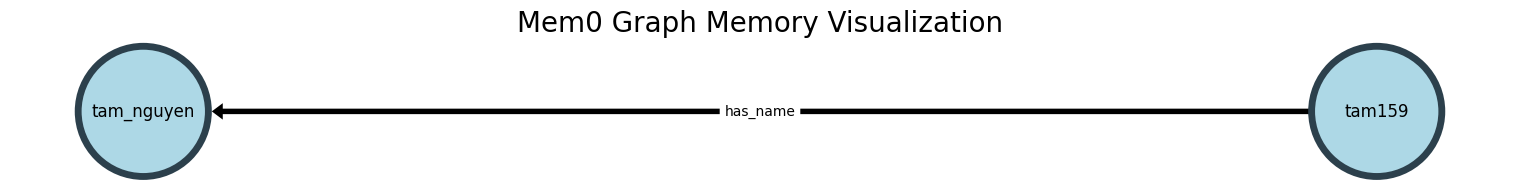

({'message': 'ok'}, None)

In [10]:
m.add("My name is Tam Nguyen", user_id=user_id), display_graph()

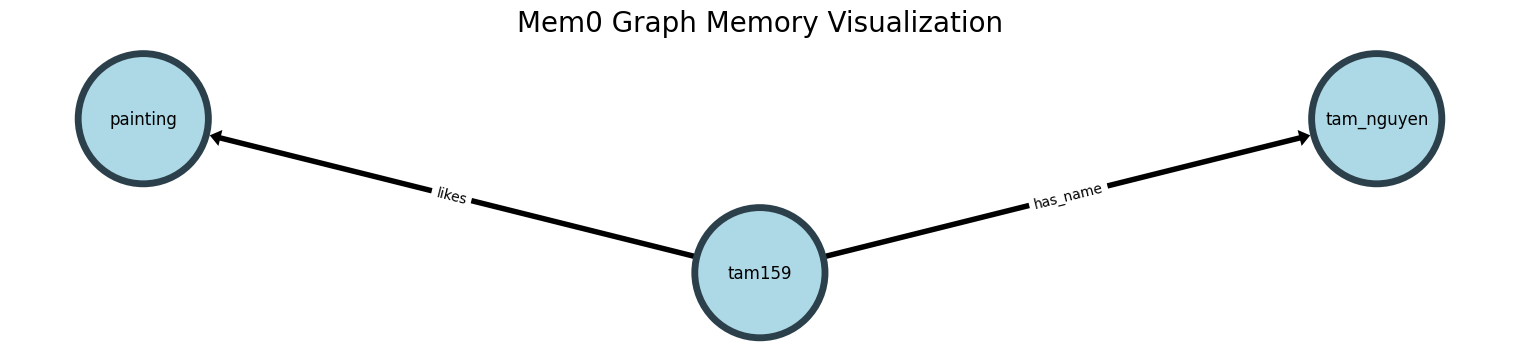

({'message': 'ok'}, None)

In [11]:
m.add("I like painting", user_id=user_id), display_graph()

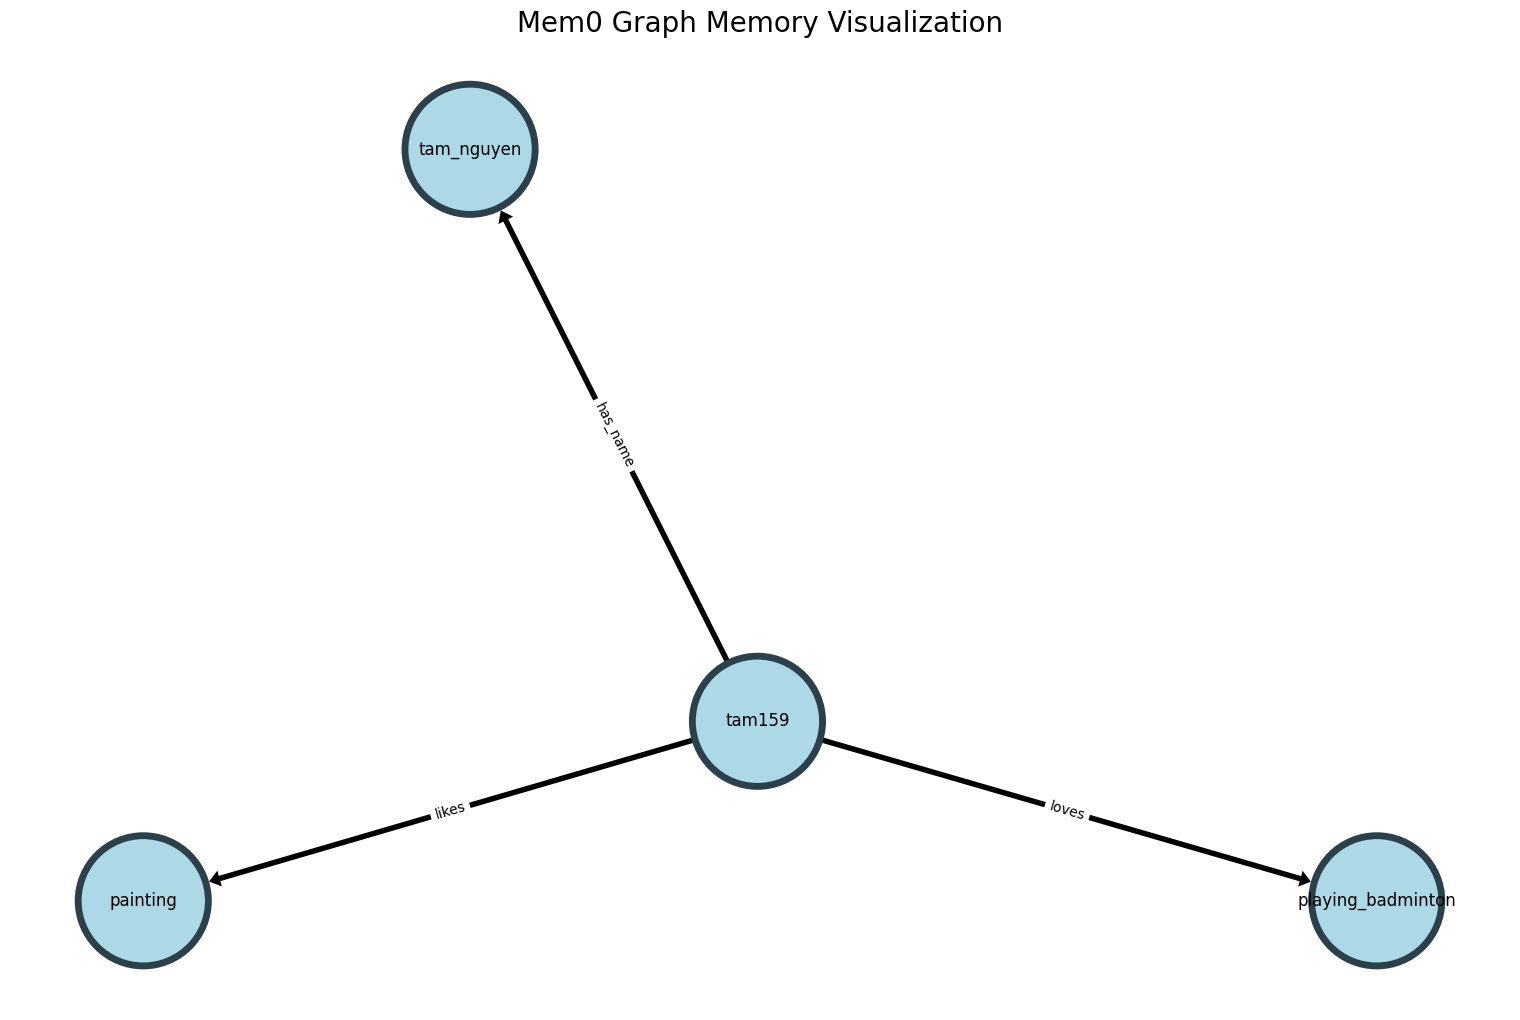

({'message': 'ok'}, None)

In [12]:
m.add("I love to play badminton", user_id=user_id), display_graph()

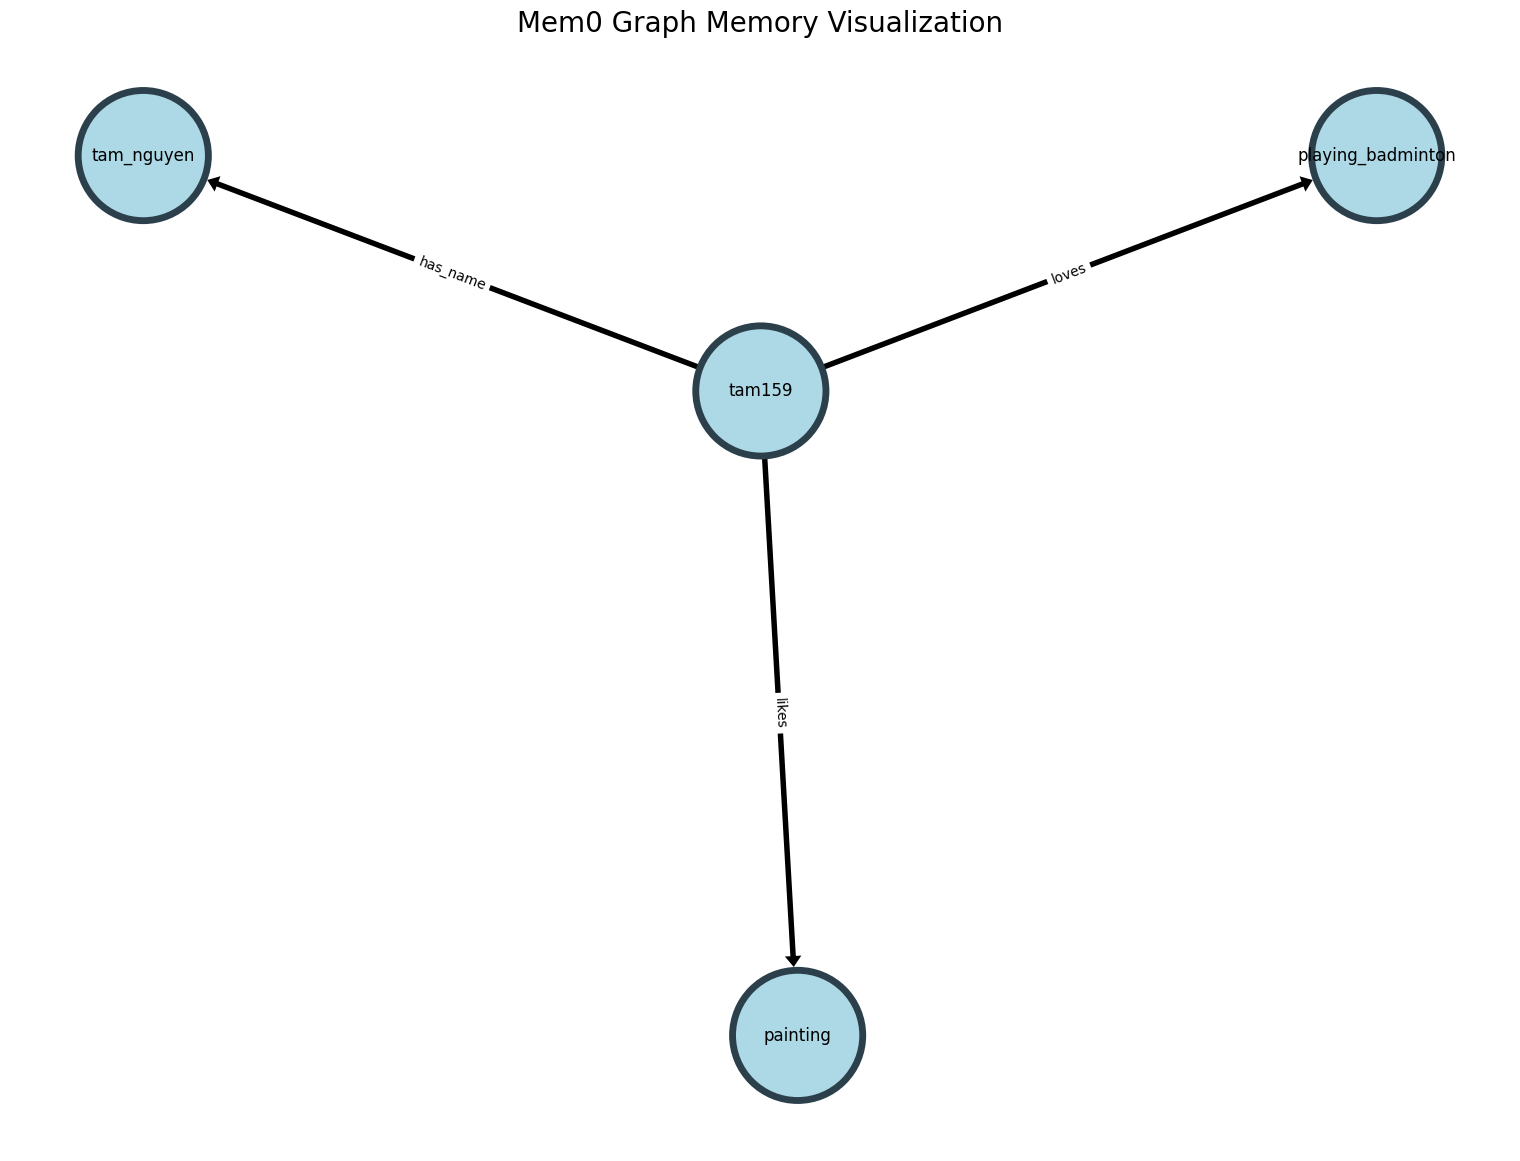

({'message': 'ok'}, None)

In [13]:
m.add("I hate playing badminton", user_id=user_id), display_graph()

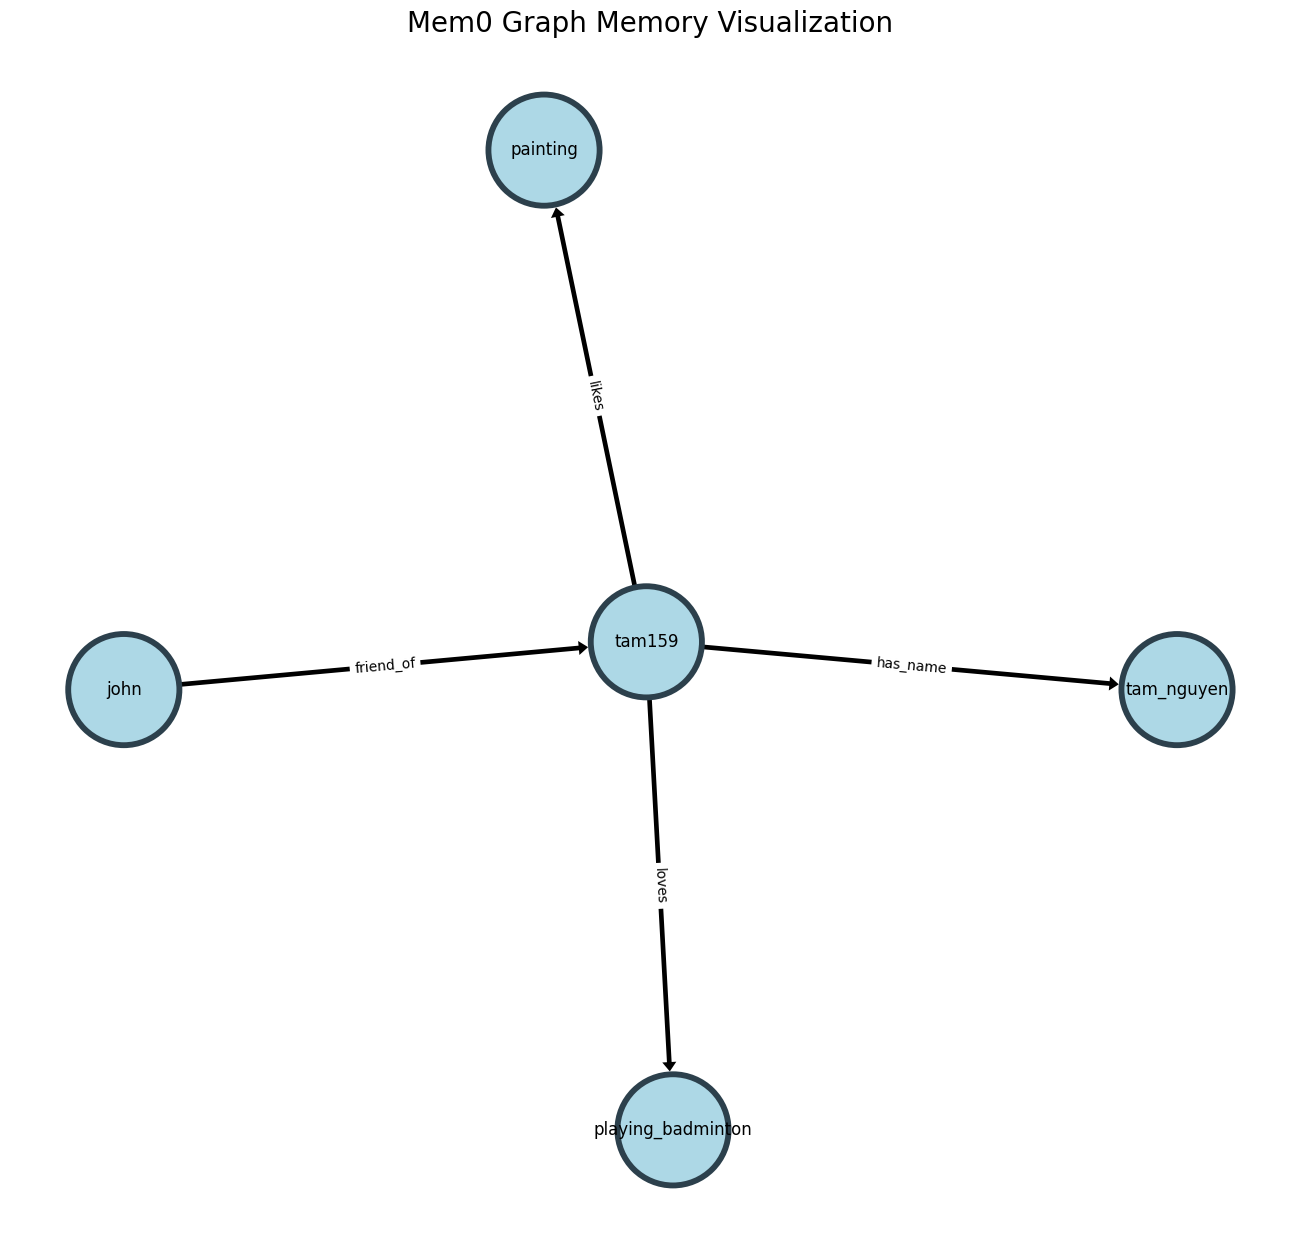

({'message': 'ok'}, None)

In [14]:
m.add("My friend name is john and john has a dog named tommy", user_id=user_id), display_graph()

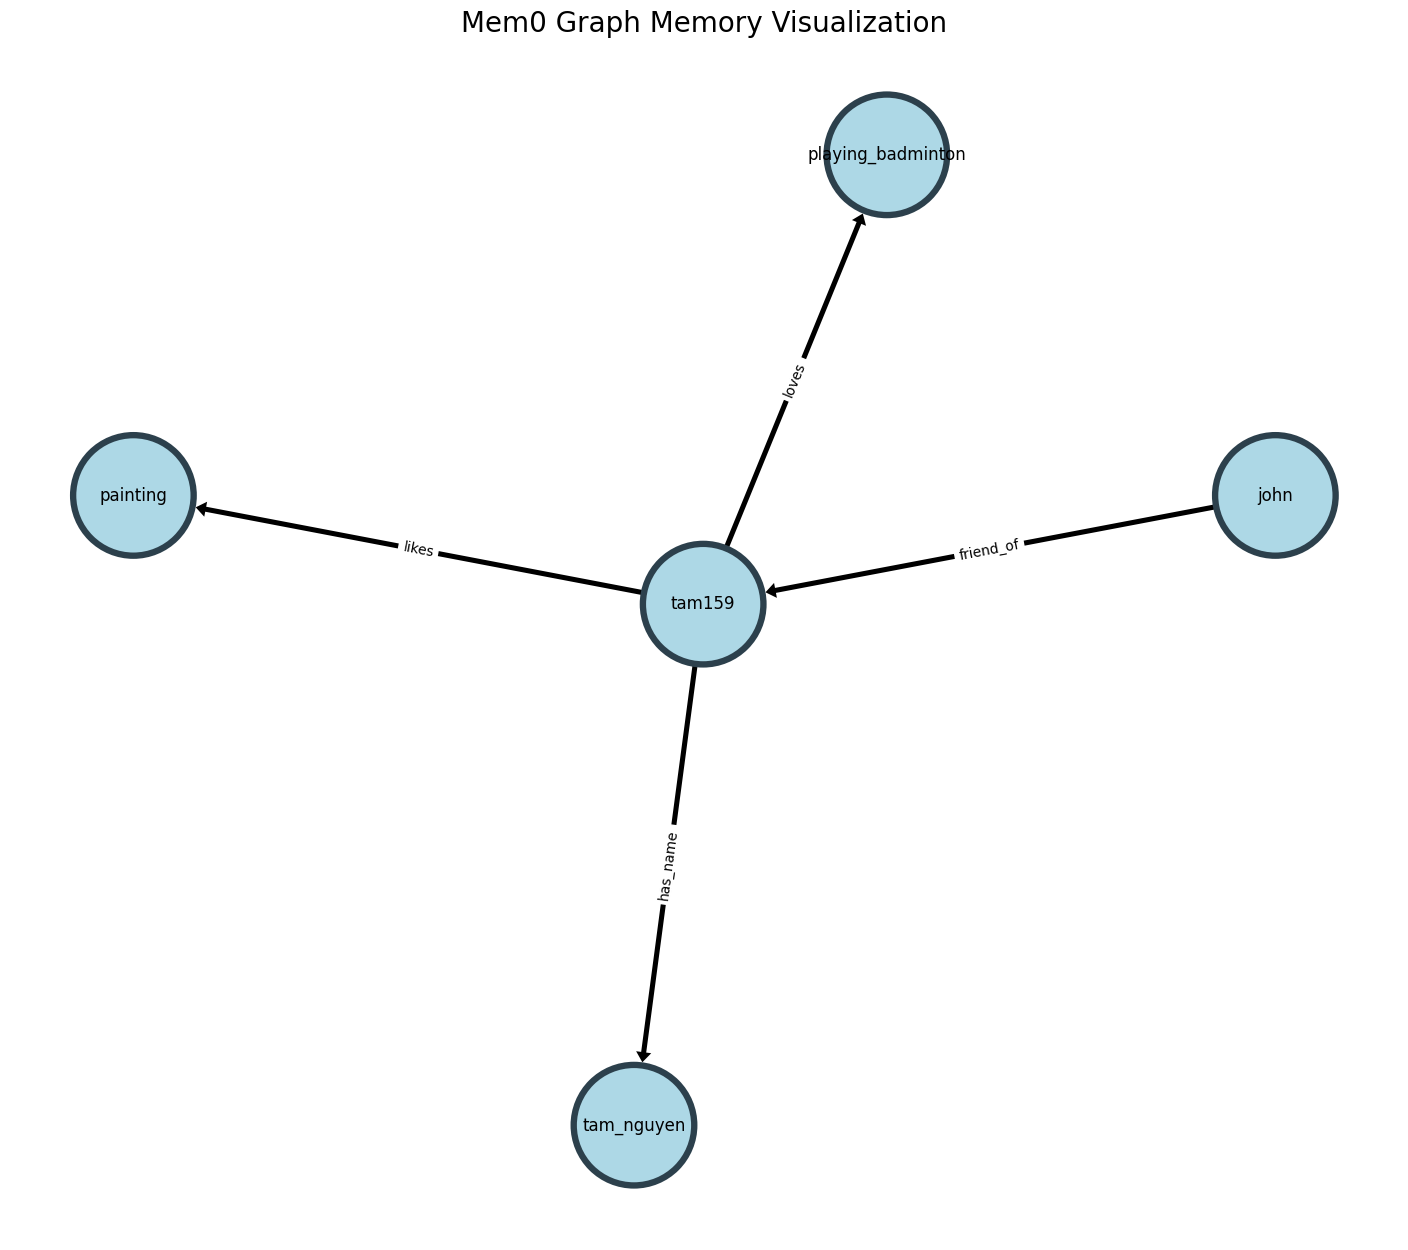

({'message': 'ok'}, None)

In [15]:
m.add("John loves to hike and Harry loves to hike as well", user_id=user_id), display_graph()

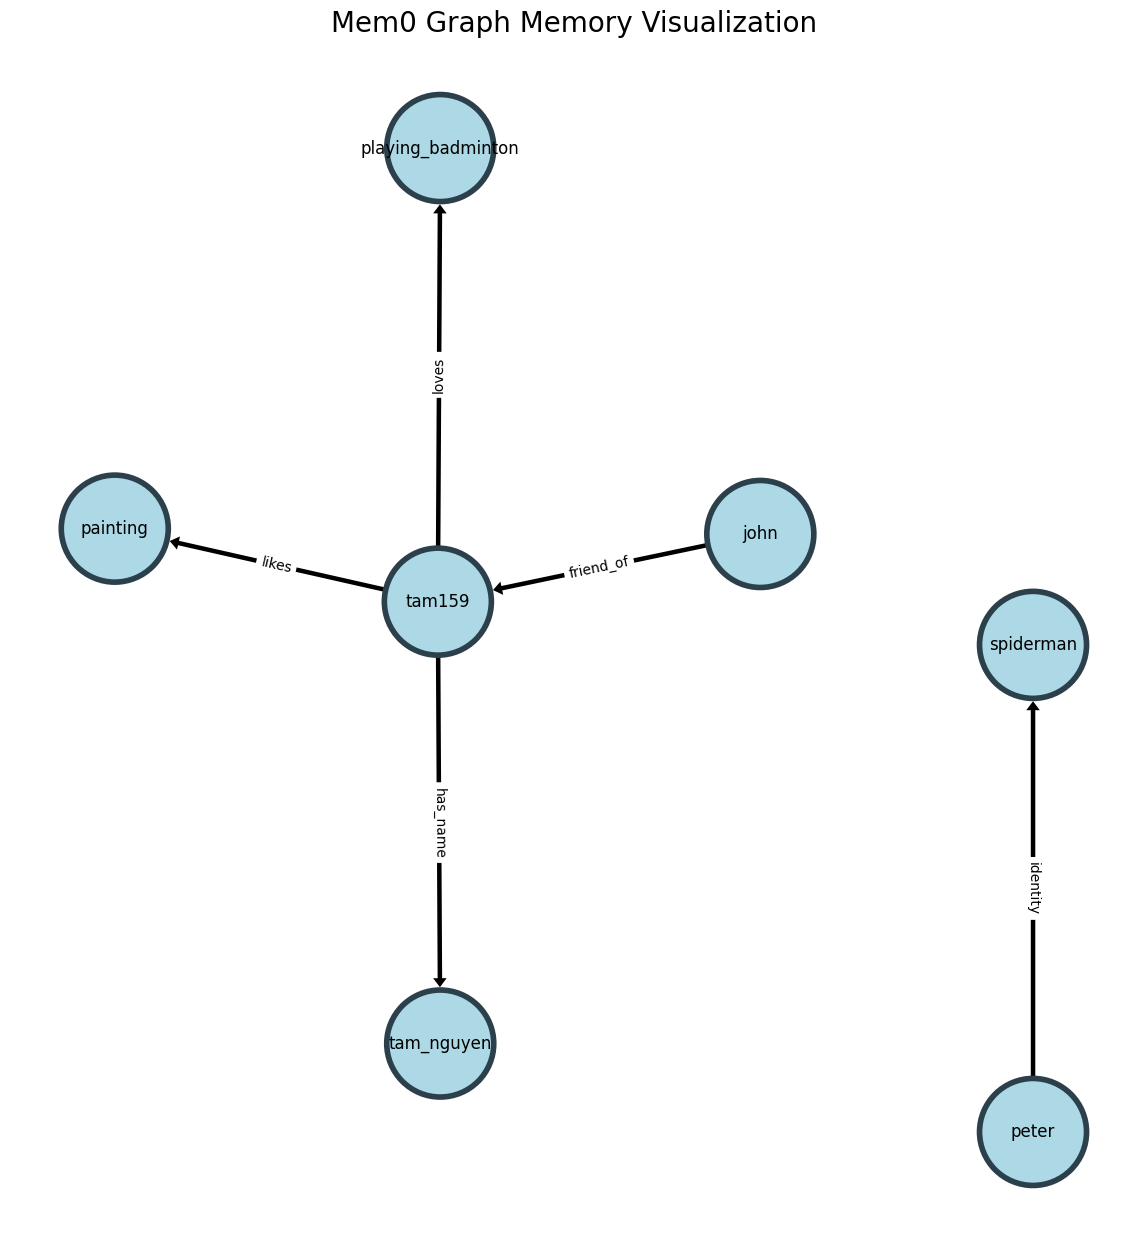

({'message': 'ok'}, None)

In [16]:
m.add("My friend peter is the spiderman", user_id=user_id), display_graph()

## Get all memories from Graph Memory

In [18]:
m.get_all(user_id=user_id)

{'memories': [{'id': '7be92e87-06a8-426c-9477-f8c284ceffd5',
   'memory': 'Name is Tam Nguyen',
   'hash': '25e1d43521189d47913c9d726ffc998b',
   'metadata': None,
   'created_at': '2024-09-09T18:57:50.455355-07:00',
   'updated_at': None,
   'user_id': 'tam159'},
  {'id': 'f54d7ed9-f3a5-49bc-bd90-9dd152fdfc61',
   'memory': 'Likes painting',
   'hash': '8fc874722a8eb7df25eaba02c88fc030',
   'metadata': None,
   'created_at': '2024-09-09T18:58:19.996696-07:00',
   'updated_at': None,
   'user_id': 'tam159'},
  {'id': 'cc522583-fad3-4189-bb31-f3169875e91c',
   'memory': "Friend's name is John",
   'hash': '26787975c6a8668ff45d0d9ebd482b39',
   'metadata': None,
   'created_at': '2024-09-09T19:00:13.143069-07:00',
   'updated_at': None,
   'user_id': 'tam159'},
  {'id': 'e218e60c-da4a-4e46-b389-e5ed45543fbc',
   'memory': 'John has a dog named Tommy',
   'hash': '0416b49b6d2af65ac00fa69f03385684',
   'metadata': None,
   'created_at': '2024-09-09T19:00:13.466720-07:00',
   'updated_at': 

## SEARCH in Graph Memory

In [19]:
m.search("Who is spiderman?", user_id=user_id)

{'memories': [{'id': 'e218e60c-da4a-4e46-b389-e5ed45543fbc',
   'memory': 'John has a dog named Tommy',
   'hash': '0416b49b6d2af65ac00fa69f03385684',
   'metadata': None,
   'score': 0.8035975513698126,
   'created_at': '2024-09-09T19:00:13.466720-07:00',
   'updated_at': None,
   'user_id': 'tam159'},
  {'id': 'cc522583-fad3-4189-bb31-f3169875e91c',
   'memory': "Friend's name is John",
   'hash': '26787975c6a8668ff45d0d9ebd482b39',
   'metadata': None,
   'score': 0.8256188436973781,
   'created_at': '2024-09-09T19:00:13.143069-07:00',
   'updated_at': None,
   'user_id': 'tam159'},
  {'id': 'cf2eb2bd-bd68-4ec4-b7c2-bbc16abe59d7',
   'memory': 'Harry loves to hike',
   'hash': '2a2e80ab0b83e4f2ebec8456712ed23d',
   'metadata': None,
   'score': 0.8469657989164708,
   'created_at': '2024-09-09T19:01:25.025046-07:00',
   'updated_at': None,
   'user_id': 'tam159'},
  {'id': '69824f90-318e-4e65-aa35-fddfb463e737',
   'memory': 'John loves to hike',
   'hash': 'e6282e7e388eae963f214f45c

#### Note: If you want to use a managed version of [Mem0](https://app.mem0.ai/), please check out Mem0.